In [45]:
#common imports
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from class_and_functions_for_combinations import *


def save_fig(name, fig):
    fig.savefig(f'thesis_figures/{name}.eps', format='eps', dpi=10000, bbox_inches='tight')

#define standard matplotlib colors
C1 = (155/255, 0/255 ,20/255)
C2 = (1.1*4/255, 1.1*100/255, 1.1*218/255)#(4/255, 100/255, 218/255)

assert False, 'Do not do a run all, it is designed to be run cell by cell, and will fail if you do a run all'

AssertionError: Do not do a run all, it is designed to be run cell by cell, and will fail if you do a run all

MSE:  19.63039
MAE:  3.7011592


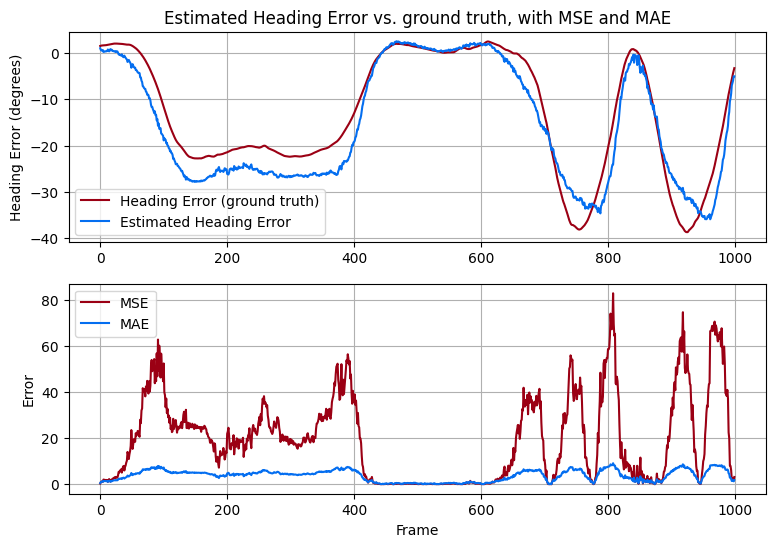

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [46]:
# PERFORMANCE METRCIS: MSE
ds_name = 'saved_tests/cw0.npz'
ds = np.load(ds_name)
imgs, locs = ds['imgs'], ds['locs']
path = np.load('sparcs/sparcs_path_precise.npy').T
onnx_model_path = 'Simulator/models/lane_keeper_ahead.onnx'
onnx_model = cv.dnn.readNetFromONNX(onnx_model_path)
dist_ahead = 0.8

hes, est_hes, MSEs, MAEs = [], [], [], []
for i in range(1000):
    img = imgs[i]
    x,y,yaw = locs[i]

    he, _, _ = get_heading_error(x, y, yaw, path, dist_ahead)
    est_he = get_est_heading_error(img, onnx_model)

    #convert to degrees
    he = np.rad2deg(he)
    est_he = np.rad2deg(est_he)

    mse = (he - est_he)**2
    mae = np.abs(he - est_he)

    hes.append(he)
    est_hes.append(est_he)
    MSEs.append(mse)
    MAEs.append(mae)

print('MSE: ', np.mean(MSEs))
print('MAE: ', np.mean(MAEs))

hes, est_hes, MSEs, MAEs = np.array(hes), np.array(est_hes), np.array(MSEs), np.array(MAEs)

#plot
fig, ax = plt.subplots(2,1, figsize=(9,6))
ax[0].plot(hes, label='Heading Error (ground truth)', color=C1)
ax[0].plot(est_hes, label='Estimated Heading Error', color=C2)
ax[0].set_ylabel('Heading Error (degrees)')
ax[0].legend()
ax[0].grid(True)
ax[0].set_axisbelow(True)
#title
ax[0].set_title('Estimated Heading Error vs. ground truth, with MSE and MAE')

ax[1].plot(MSEs, label='MSE', color=C1)
ax[1].plot(MAEs, label='MAE', color=C2)
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Error')
ax[1].legend()
ax[1].grid(True)
ax[1].set_axisbelow(True)
#y axis in log scale
# ax[1].set_yscale('log')

plt.show()

#save figure in vector format
save_fig('performance_metrics_example', fig)



100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


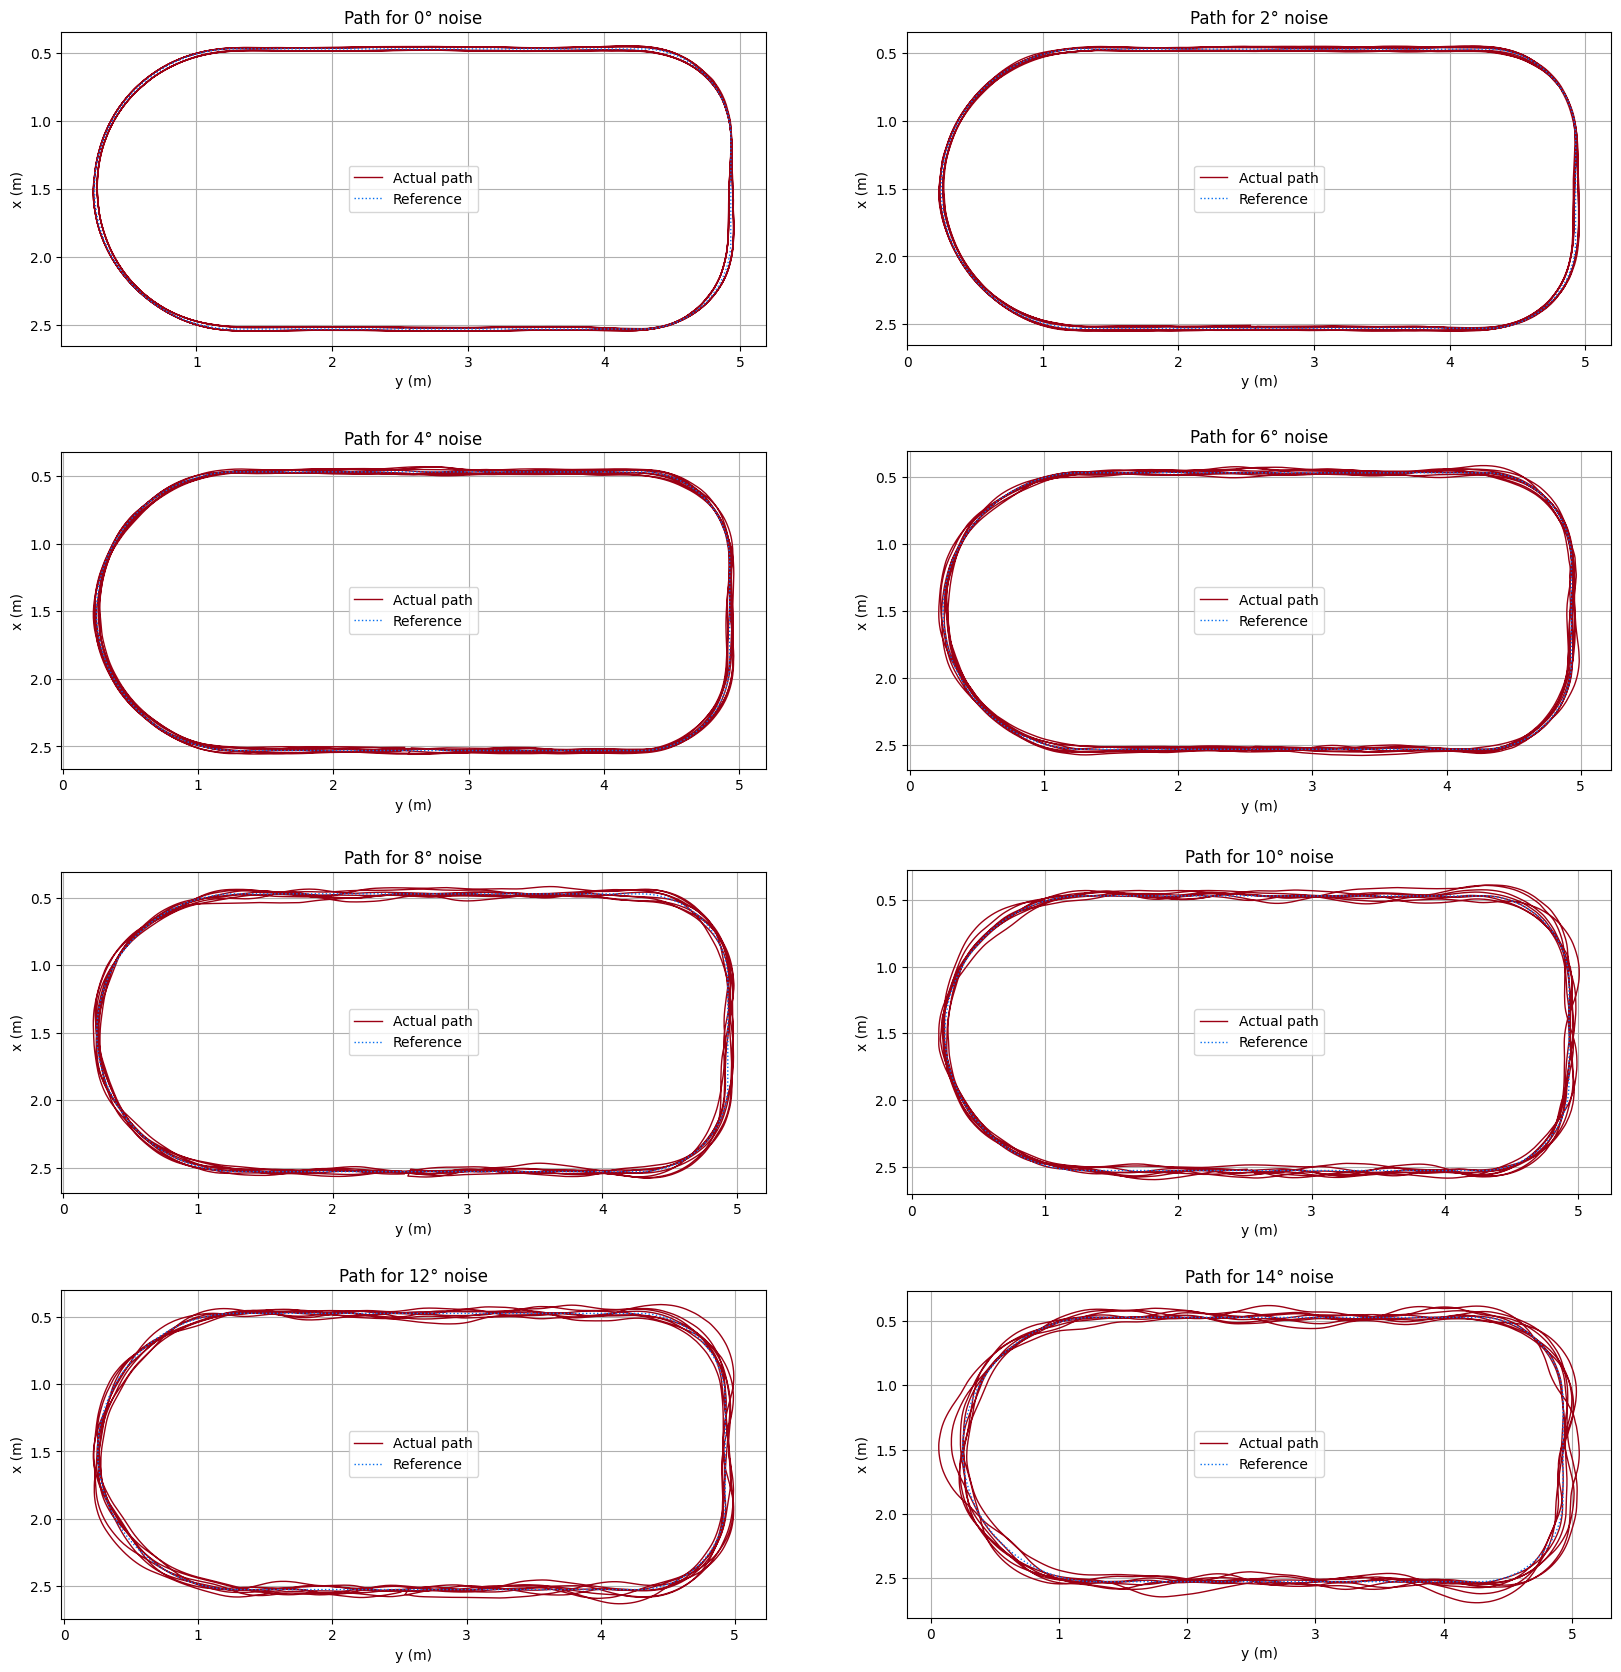

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [48]:
# DATASET ANALYSIS 1
names = ['cw0', 'cw2', 'cw4', 'cw6', 'cw8', 'cw10', 'cw12', 'cw14', 'acw0', 'acw2', 'acw4', 'acw6', 'acw8', 'acw10', 'acw12', 'acw14']
folder = 'tmp/real_dss/'
he_dists = [.2,.3,.4,.5,.6,.7,.8,.9]

dss = []
for i in tqdm(range(8)):
    name = names[i]
    #keep only the numbers
    val_name = name[2:]
    cw = my_load(folder + names[i] + '.npz')
    acw = my_load(folder + names[i+8] + '.npz')
    cw_imgs, cw_locs = cw['imgs'], cw['locs']
    acw_imgs, acw_locs = acw['imgs'], acw['locs']
    imgs = np.concatenate((cw_imgs, acw_imgs))
    locs = np.concatenate((cw_locs, acw_locs))

    hes = {}
    for he_dist in he_dists:
        cwhe_name = f'tmp/hes/{names[i]}_{he_dist*100:.0f}.npz'
        acwhe_name = f'tmp/hes/{names[i+8]}_{he_dist*100:.0f}.npz'
        cwhe = my_load(cwhe_name)
        acwhe = my_load(acwhe_name)
        cw_hes = cwhe['hes']
        acw_hes = acwhe['hes']
        hes[he_dist] = np.concatenate((cw_hes, acw_hes))

    dss.append({'name': val_name, 'imgs': imgs, 'locs': locs, 'hes': hes})

path = np.load('sparcs/sparcs_path_precise.npy').T


#create figure
fig, ax = plt.subplots(4,2, figsize=(20,21))

for i, ds in enumerate(dss):
    imgs, locs, hes, name = ds['imgs'], ds['locs'], ds['hes'], ds['name']
    #plot
    ax[i//2, i%2].plot(locs[:,1], locs[:,0], label='Actual path', color=C1, linestyle='-', linewidth=1)
    ax[i//2, i%2].grid(True)
    ax[i//2, i%2].set_axisbelow(True)
    ax[i//2, i%2].set_aspect('equal')
    ax[i//2, i%2].plot(path[:,1], path[:,0], label='Reference', color=C2, linestyle=':', linewidth=1)
    ax[i//2, i%2].set_title(f'Path for {name}° noise')
    ax[i//2, i%2].legend()
    #invert y axis
    ax[i//2, i%2].invert_yaxis()
    ax[i//2, i%2].set_xlabel('y (m)')
    ax[i//2, i%2].set_ylabel('x (m)')

#show fig
plt.show()

#save figure in vector format
save_fig('dataset_analysis1', fig)


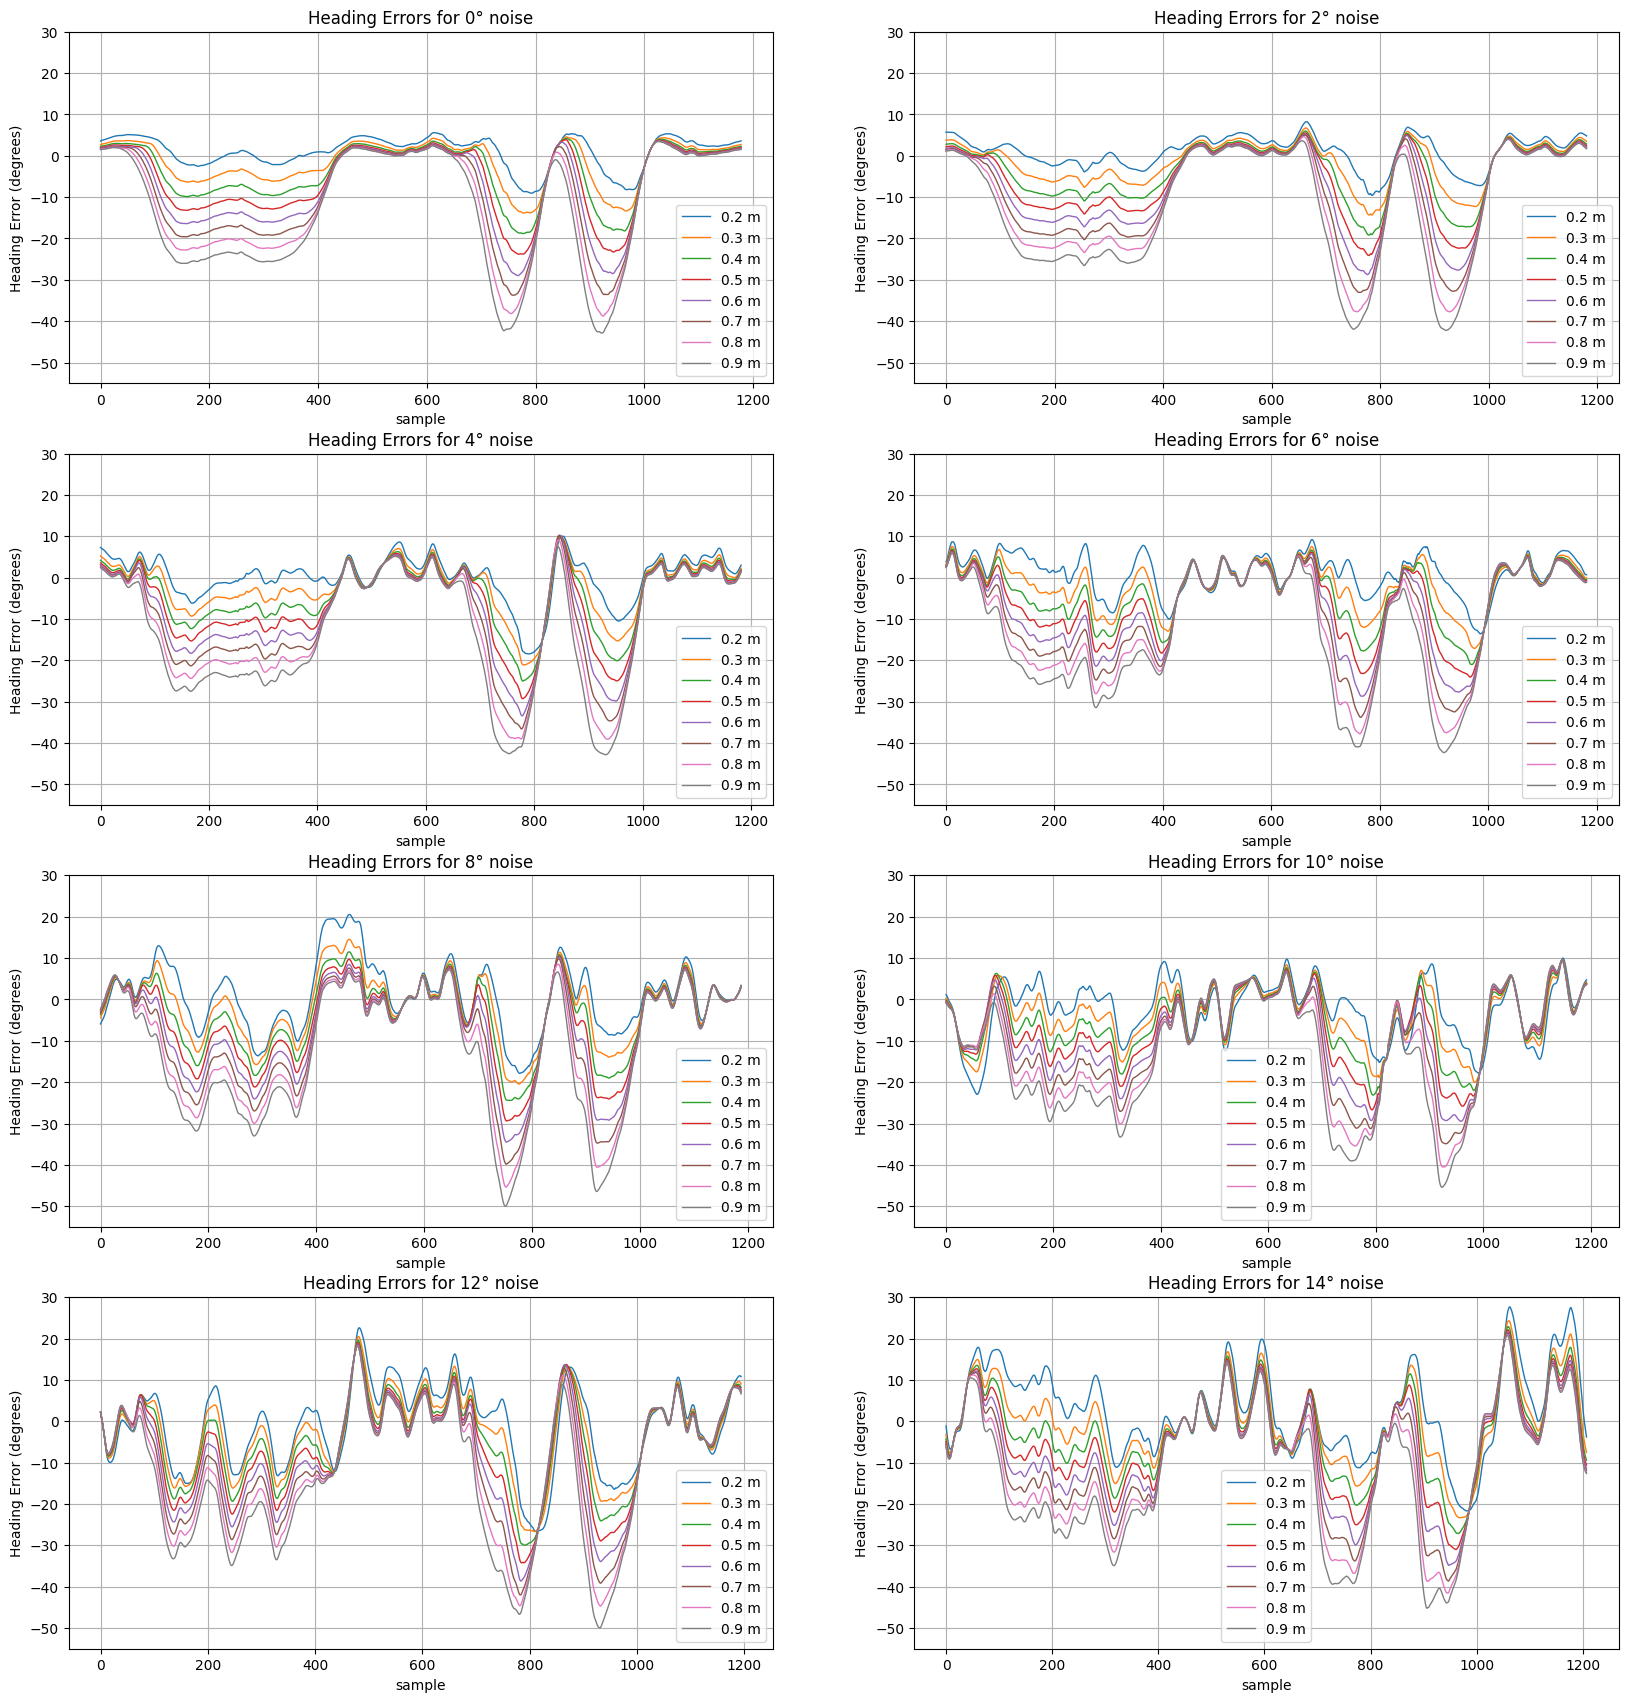

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [59]:
# DATASET ANALYSIS 2
#check dss exists
assert len(dss) > 0

#create figure
fig, ax = plt.subplots(4,2, figsize=(20,21))

for i, ds in enumerate(dss):
    hes, name = ds['hes'], ds['name']
    #select only the first 1/8 of the data
    hes = {k: v[:len(v)//8] for k, v in hes.items()}

    #plot
    for he_dist, he in hes.items():
        he = np.rad2deg(he)
        ax[i//2, i%2].plot(he, label=f'{he_dist} m', linewidth=1)

    ax[i//2, i%2].grid(True)
    ax[i//2, i%2].set_axisbelow(True)
    ax[i//2, i%2].set_title(f'Heading Errors for {name}° noise')
    ax[i//2, i%2].legend()
    ax[i//2, i%2].set_ylim(-55, 30)
    ax[i//2, i%2].set_xlabel('sample')
    ax[i//2, i%2].set_ylabel('Heading Error (degrees)')

#show fig
plt.show()

#save figure in vector format
save_fig('dataset_analysis2', fig)

